E Card Game

   [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repo/blob/main/simulation.ipynb)

In [41]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [40]:
#check if GPU is available
torch.cuda.is_available()

True

In [14]:
def outcome_game(player1_card, player2_card):
    # Determine winner of a single draw:
    # return 1 if player1 (first player passed) wins the draw,
    # return -1 if player2 wins the draw,
    # return 0 if tie.
    if player1_card == player2_card:
        return 0
    # Winning rules: Emperor (K) beats Citizen (C); Citizen (C) beats Slave (S); Slave (S) beats Emperor (K)
    if player1_card == "K" and player2_card == "C":
        return 1
    if player1_card == "C" and player2_card == "S":
        return 1
    if player1_card == "S" and player2_card == "K":
        return 1
    # Otherwise player2 wins the draw
    return -1
    
    

In [15]:
def random_policy(hand, opponent_hand=None):
    #from hand, play a random card
    return hand.pop(random.randint(0, len(hand) - 1))

In [16]:
def yolo_policy(hand, opponent_hand=None):
    # Play special card (K or S) if available
    if "K" in hand:
        hand.remove("K")
        return "K"
    if "S" in hand:
        hand.remove("S")
        return "S"
    # Otherwise play random C
    return hand.pop(random.randint(0, len(hand) - 1))

In [17]:
def minimax_policy(hand, opponent_hand=None):
    """
    Minimax policy: Assumes opponent plays optimally and chooses the move
    that maximizes the worst-case outcome.
    """
    if opponent_hand is None or len(opponent_hand) == 0:
        # Fallback to random if no opponent info
        return hand.pop(random.randint(0, len(hand) - 1))
    
    # Get unique cards we can play
    available_cards = list(set(hand))
    
    # Evaluate each possible move
    best_card = None
    best_value = float('-inf')
    
    for my_card in available_cards:
        # For this card, find worst-case outcome against opponent's best response
        worst_value = float('inf')
        
        opponent_cards = list(set(opponent_hand))
        for opp_card in opponent_cards:
            # Calculate outcome if opponent plays this card
            result = outcome_game(my_card, opp_card)
            worst_value = min(worst_value, result)
        
        # Choose the move with the best worst-case outcome
        if worst_value > best_value:
            best_value = worst_value
            best_card = my_card
    
    # Remove and return the chosen card
    hand.remove(best_card)
    return best_card

In [18]:
def expectimax_policy(hand, opponent_hand=None):
    """
    Expectimax policy: Chooses the card that maximizes expected value
    based on the probability distribution of opponent's remaining cards.
    """
    if opponent_hand is None or len(opponent_hand) == 0:
        # Fallback to random if no opponent info
        return hand.pop(random.randint(0, len(hand) - 1))
    
    # Get unique cards we can play
    available_cards = list(set(hand))
    
    # Count opponent's cards to estimate probabilities
    opp_card_counts = {}
    for card in opponent_hand:
        opp_card_counts[card] = opp_card_counts.get(card, 0) + 1
    
    total_opp_cards = len(opponent_hand)
    
    # Calculate expected value for each of our possible moves
    best_card = None
    best_expected_value = float('-inf')
    
    for my_card in available_cards:
        expected_value = 0.0
        
        # Calculate expected outcome against opponent's distribution
        for opp_card, count in opp_card_counts.items():
            probability = count / total_opp_cards
            outcome = outcome_game(my_card, opp_card)
            expected_value += probability * outcome
        
        # Choose the card with highest expected value
        if expected_value > best_expected_value:
            best_expected_value = expected_value
            best_card = my_card
    
    # Remove and return the chosen card
    hand.remove(best_card)
    return best_card

In [19]:
slave_deck = ["C","C","C","C","S"]
king_deck = ["C","C","C","C","K"]


class Player:
    def __init__(self, name, hand,policy):
        self.name = name
        self.original_hand = hand.copy()  # Create a copy to avoid modifying the input
        self.hand = self.original_hand.copy()
        self.score = 0
        self.policy = policy
    def play_card(self, opponent_hand=None):
        #play a card based on the policy
        card_drawn = self.policy(self.hand, opponent_hand)
        #print(self.hand)
        return card_drawn
    def reset_hand(self):
        self.hand = self.original_hand.copy()
    def reset_score(self):
        self.score = 0

In [20]:
#single game class
class Round():
    def __init__(self, player1, player2):
        self.player1 = player1
        self.player2 = player2

    def play_round(self):
        # self.player1.reset_hand()
        # self.player2.reset_hand()
        # self.player1.reset_score()
        # self.player2.reset_score()
        while self.player1.hand and self.player2.hand:
            # Snapshot hands before moves to ensure simultaneous decision making
            p1_hand_snapshot = self.player1.hand.copy()
            p2_hand_snapshot = self.player2.hand.copy()

            # policies receive (player, opponent) and must remove/return a card from player's deck
            # We pass the snapshot of the opponent's hand so they see the full hand including the card being played
            card1 = self.player1.play_card(p2_hand_snapshot)
            card2 = self.player2.play_card(p1_hand_snapshot)
            
            #print(card1,card2)
            # determine draw outcome: 1 -> player1 wins draw, -1 -> player2 wins draw, 0 -> tie
            result = outcome_game(card1, card2)
            if result != 0:
                #print("Game done," + (" player 1 wins" if result > 0 else " player 2 wins"))
                # score is applied at match level (Game.play_one_match) so this single draw returns the result
                #reset hands
                self.player1.reset_hand()
                self.player2.reset_hand()
                #print(card1,card2,result)
                return card1, card2, result
        # if decks empty without winner, return tie, imposible situation
        return None, None, 0

In [21]:
# --- Environment ---
class ECardEnv:
    def __init__(self, opponent_policy=None):
        king_deck = ["C", "C", "C", "C", "K"]
        slave_deck = ["C", "C", "C", "C", "S"]
        
        if opponent_policy is None:
            opponent_policy = random_policy
        
        # Agent's policy will be injected dynamically at each step
        self.agent = Player("King", king_deck, policy=None) 
        # Opponent has a fixed policy
        self.opponent = Player("Slave", slave_deck, policy=opponent_policy)
        
        self.reset()
        
    def reset(self):
        self.agent.reset_hand()
        self.opponent.reset_hand()
        return self._get_state()
    
    def _get_state(self):
        my_k = self.agent.hand.count("K")
        my_c = self.agent.hand.count("C")
        opp_s = self.opponent.hand.count("S")
        opp_c = self.opponent.hand.count("C")
        return np.array([my_k, my_c, opp_s, opp_c], dtype=np.float32)
    
    def step(self, action):
        # --- 1. Define Agent's Policy for this Step ---
        # We translate the RL 'action' into a callable policy function
        # This satisfies the requirement: "play the action based off the policy given"
        
        def step_action_policy(hand, opp_hand):
            # Determine target card based on action and role
            # Action 0: Play Citizen (C)
            # Action 1: Play Special (K or S)
            target_card = "C"
            if action == 1:
                if "K" in hand:
                    target_card = "K"
                elif "S" in hand:
                    target_card = "S"
            
            # Validity Check & Removal
            if target_card in hand:
                hand.remove(target_card)
                return target_card
            
            # Fallback (Masking): If invalid, play whatever is valid
            if hand:
                fallback = hand[0] 
                hand.remove(fallback)
                return fallback
            return None

        # Assign this specific policy to the agent
        self.agent.policy = step_action_policy
        
        # --- 2. Execute Plays via Player Class ---
        agent_card = self.agent.play_card(self.opponent.hand)
        
        if not self.opponent.hand:
             return self._get_state(), 0, True 
             
        opp_card = self.opponent.play_card(self.agent.hand)
        
        # --- 3. Determine Outcome ---
        result = outcome_game(agent_card, opp_card)
        
        reward = 0
        done = False
        
        if result == 1:
            reward = 1
            done = True
        elif result == -1:
            reward = -1 
            done = True
        else:
            # Tie
            reward = 0
            if not self.agent.hand: # No cards left
                done = True
                
        return self._get_state(), reward, done

    def get_valid_actions(self):
        valid = []
        if "C" in self.agent.hand:
            valid.append(0)
        if "K" in self.agent.hand:
            valid.append(1)
        return valid

In [22]:
class PolicyComparison:
    """
    Class to compare a King policy against a Slave policy.
    """
    def __init__(self, king_policy, slave_policy, king_name="King", slave_name="Slave"):
        """
        Initialize with two policies to compare.
        
        Args:
            king_policy: Policy function for King player
            slave_policy: Policy function for Slave player
            king_name: Name/label for the King's policy
            slave_name: Name/label for the Slave's policy
        """
        self.king_policy = king_policy
        self.slave_policy = slave_policy
        self.king_name = king_name
        self.slave_name = slave_name
        self.results = None
    def reset(self):
        self.results = None
        
        
    def run_simulation(self,n_rounds_list = [100, 1000, 10000, 100000], replicates=100):
        """
        Run simulation comparing the two policies.
        
        Args:
            n_rounds: Number of rounds per replicate
            n_replicates: Number of replicates to run
        """
        
        # Initialize Env with slave policy
        env = ECardEnv(opponent_policy=self.slave_policy)
        
        king_scores = []
        slave_scores = []
        for n_rounds in n_rounds_list:
            replicates_scores_king = []
            replicates_scores_slave = []
            for i in range(replicates):
                current_king_score = 0
                current_slave_score = 0
                
                for j in range(n_rounds):
                    env.reset()
                    done = False
                    while not done:
                        # Decide action using king_policy
                        # Pass copies so policy doesn't modify actual hand
                        card_to_play = self.king_policy(env.agent.hand.copy(), env.opponent.hand.copy())
                        
                        # Convert card to action
                        action = 0 # Play C
                        if card_to_play == "K" or card_to_play == "S":
                            action = 1 # Play Special
                            
                        _, reward, done = env.step(action)
                        
                        if reward == 1:
                            current_king_score += 1
                        elif reward == -1:
                            current_slave_score += 4
                            
                replicates_scores_king.append(current_king_score)
                replicates_scores_slave.append(current_slave_score)
            # Calculate average score per round
            king_scores.append((sum(replicates_scores_king) / replicates) / n_rounds)
            slave_scores.append((sum(replicates_scores_slave) / replicates) / n_rounds)

        plt.plot(n_rounds_list, king_scores, label="King")
        plt.plot(n_rounds_list, slave_scores, label="Slave")
        plt.xlabel("Number of Rounds")
        plt.ylabel("Average Score per Round")
        plt.title("Convergence of Average Score (King " + self.king_name + " vs Slave " + self.slave_name + ")")
        plt.legend()
        plt.xscale('log') # Log scale helps visualize the orders of magnitude better
        plt.show()
    
    

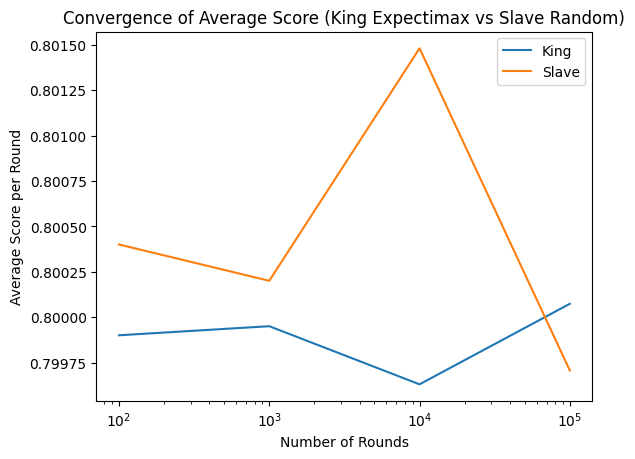

In [23]:
comparison = PolicyComparison(
    king_policy=expectimax_policy,
    slave_policy=random_policy,
    king_name="Expectimax",
    slave_name="Random"
)

# Run simulation
comparison.run_simulation()


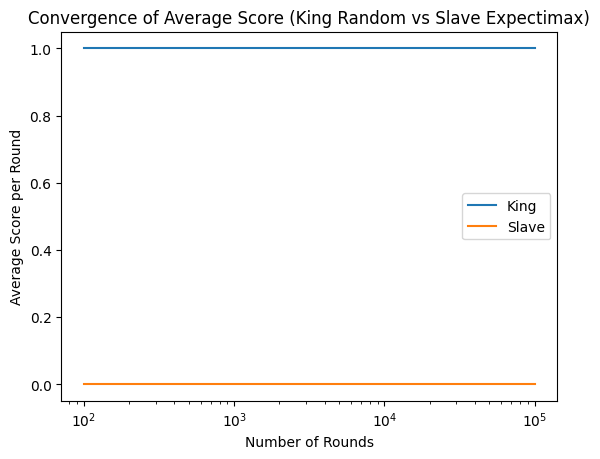

In [24]:
comparison = PolicyComparison(
    king_policy=random_policy,
    slave_policy=expectimax_policy,
    king_name="Random",
    slave_name="Expectimax"
)

# Run simulation
comparison.run_simulation()

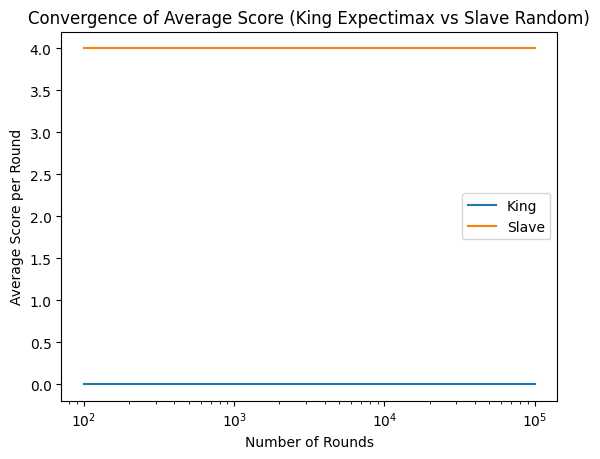

In [25]:
comparison = PolicyComparison(
    king_policy=expectimax_policy,
    slave_policy=yolo_policy,
    king_name="Expectimax",
    slave_name="YOLO"
)

# Run simulation
comparison.run_simulation()


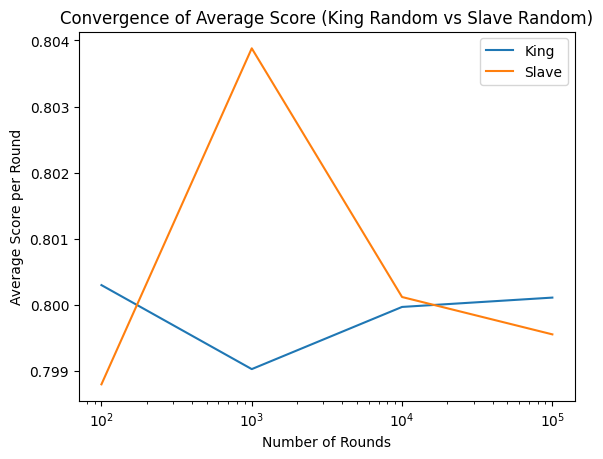

In [26]:
comparison = PolicyComparison(
    king_policy=random_policy,
    slave_policy=random_policy,
    king_name="Random",
    slave_name="Random"
)

# Run simulation
comparison.run_simulation()


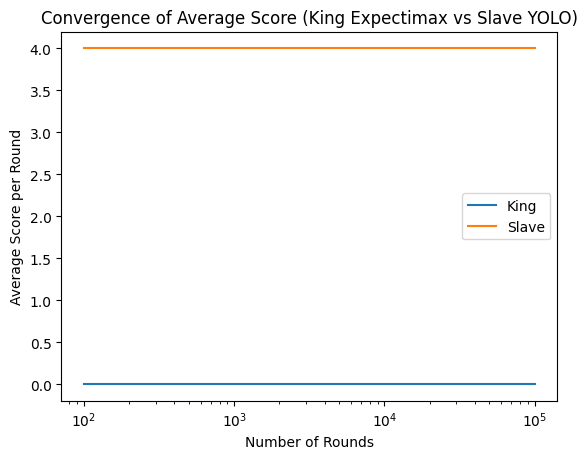

In [27]:
comparison = PolicyComparison(
    king_policy=expectimax_policy,
    slave_policy=yolo_policy,
    king_name="Expectimax",
    slave_name="YOLO"
)

# Run simulation
comparison.run_simulation()


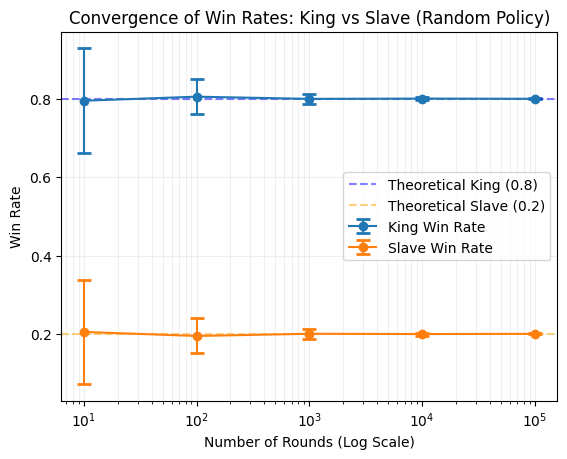


Summary Statistics:

n = 10 rounds:
  King:  Mean = 0.7950, SD = 0.1337
  Slave: Mean = 0.2050, SD = 0.1337

n = 100 rounds:
  King:  Mean = 0.8053, SD = 0.0447
  Slave: Mean = 0.1947, SD = 0.0447

n = 1,000 rounds:
  King:  Mean = 0.7997, SD = 0.0123
  Slave: Mean = 0.2003, SD = 0.0123

n = 10,000 rounds:
  King:  Mean = 0.8004, SD = 0.0037
  Slave: Mean = 0.1996, SD = 0.0037

n = 100,000 rounds:
  King:  Mean = 0.7999, SD = 0.0011
  Slave: Mean = 0.2001, SD = 0.0011


In [28]:
# Simulation to verify win probabilities (King ~0.8, Slave ~0.2)

# Setup simulation parameters
n_rounds_list = [10, 100, 1000, 10000, 100000]
n_replicates = 100

# Store results for each replicate
king_win_rates_all = []
slave_win_rates_all = []

# Initialize players with random policy
king_sim = Player("king", king_deck, random_policy)
slave_sim = Player("slave", slave_deck, random_policy)
round_sim = Round(king_sim, slave_sim)

for n in n_rounds_list:
    king_rates_replicates = []
    slave_rates_replicates = []
    
    for rep in range(n_replicates):
        king_wins = 0
        slave_wins = 0
        for _ in range(n):
            # play_round returns (card1, card2, result)
            # result 1 = King wins, -1 = Slave wins
            _, _, result = round_sim.play_round()
            
            if result == 1:
                king_wins += 1
            elif result == -1:
                slave_wins += 1
        
        king_rates_replicates.append(king_wins / n)
        slave_rates_replicates.append(slave_wins / n)
    
    king_win_rates_all.append(king_rates_replicates)
    slave_win_rates_all.append(slave_rates_replicates)

# Calculate means and standard deviations
king_mean = [np.mean(rates) for rates in king_win_rates_all]
king_std = [np.std(rates) for rates in king_win_rates_all]
slave_mean = [np.mean(rates) for rates in slave_win_rates_all]
slave_std = [np.std(rates) for rates in slave_win_rates_all]

# Plot: Win rates with error bars
plt.errorbar(n_rounds_list, king_mean, yerr=king_std, label="King Win Rate", 
             marker='o', capsize=5, capthick=2)
plt.errorbar(n_rounds_list, slave_mean, yerr=slave_std, label="Slave Win Rate", 
             marker='o', capsize=5, capthick=2)

# Theoretical lines
plt.axhline(y=0.8, color='blue', linestyle='--', alpha=0.5, label="Theoretical King (0.8)")
plt.axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label="Theoretical Slave (0.2)")

plt.xscale('log')
plt.xlabel("Number of Rounds (Log Scale)")
plt.ylabel("Win Rate")
plt.title("Convergence of Win Rates: King vs Slave (Random Policy)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 60)
for i, n in enumerate(n_rounds_list):
    print(f"\nn = {n:,} rounds:")
    print(f"  King:  Mean = {king_mean[i]:.4f}, SD = {king_std[i]:.4f}")
    print(f"  Slave: Mean = {slave_mean[i]:.4f}, SD = {slave_std[i]:.4f}")

# Q-Learning Agent with Self-Play 

The following implementation defines a QLearningAgent that can be trained against different opponents.


The key is a tuple containing two parts: the State tuple and the Action integer.

The State: (my_K, my_S, my_C, opp_K, opp_S, opp_C)
This represents the cards currently held by both players.

Index 0 (my_K): Number of Kings you have (0 or 1). \
Index 1 (my_S): Number of Slaves you have (0 or 1). \
Index 2 (my_C): Number of Citizens you have (0 to 4). \
Index 3 (opp_K): Number of Kings opponent has. \
Index 4 (opp_S): Number of Slaves opponent has. \
Index 5 (opp_C): Number of Citizens opponent has. \
Example State: (1, 0, 4, 0, 1, 4)\
You (King side) have 1 King, 0 Slaves, 4 Citizens (Full hand).
Opponent (Slave side) has 0 Kings, 1 Slave, 4 Citizens (Full hand)

In [29]:
class QLearningAgent:
    def __init__(self, role, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.role = role  # "King" or "Slave"
        self.q_table = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.last_state = None
        self.last_action = None
        self.training_mode = True

    def get_state(self, hand, opponent_hand):
        # State: (my_K, my_S, my_C, opp_K, opp_S, opp_C)
        # We use counts to represent the state as a hashable tuple
        my_k = hand.count("K")
        my_s = hand.count("S")
        my_c = hand.count("C")
        
        opp_k = opponent_hand.count("K")
        opp_s = opponent_hand.count("S")
        opp_c = opponent_hand.count("C")
        
        return (my_k, my_s, my_c, opp_k, opp_s, opp_c)

    def get_valid_actions(self, hand):
        actions = []
        if "C" in hand:
            actions.append(0)  # Play Citizen
        if "K" in hand or "S" in hand:
            actions.append(1)  # Play Special
        return actions

    def choose_action(self, hand, opponent_hand):
        state = self.get_state(hand, opponent_hand)
        valid_actions = self.get_valid_actions(hand)
        
        if not valid_actions:
            return None, state

        if self.training_mode and random.random() < self.epsilon:
            action = random.choice(valid_actions)
        else:
            # Get Q-values for valid actions
            q_values = [self.q_table.get((state, a), 0.0) for a in valid_actions]
            max_q = max(q_values) if q_values else 0.0
            
            # Find all actions with max_q for tie-breaking
            best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
            action = random.choice(best_actions) if best_actions else random.choice(valid_actions)
            
        return action, state

    def policy(self, hand, opponent_hand):
        """
        Adapter method to make this agent compatible with the Player class and ECardEnv.
        This is used when the agent is acting as the 'opponent' in ECardEnv.
        """
        action, state = self.choose_action(hand, opponent_hand)
        
        # Store state/action for learning (used in self-play updates)
        self.last_state = state
        self.last_action = action
        
        # Execute action (remove card from hand as expected by Player class)
        card = None
        if action == 0: # Play C
            if "C" in hand:
                card = "C"
                hand.remove("C")
            else:
                card = hand.pop(0) # Fallback
        elif action == 1: # Play Special
            if "K" in hand:
                card = "K"
                hand.remove("K")
            elif "S" in hand:
                card = "S"
                hand.remove("S")
            else:
                card = hand.pop(0) # Fallback
                
        return card

    def learn(self, reward, next_hand, next_opponent_hand, done):
        if self.last_state is None or self.last_action is None:
            return

        next_state = self.get_state(next_hand, next_opponent_hand)
        next_valid_actions = self.get_valid_actions(next_hand)
        
        max_next_q = 0.0
        if not done and next_valid_actions:
            max_next_q = max([self.q_table.get((next_state, a), 0.0) for a in next_valid_actions])
            
        current_q = self.q_table.get((self.last_state, self.last_action), 0.0)
        
        # Q-learning update formula
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[(self.last_state, self.last_action)] = new_q


def train_agent(episodes=5000, opponent_type="yolo"):
    """
    Trains a King Q-Learning agent.
    
    Args:
        episodes: Number of games to train.
        opponent_type: "yolo", "random", or "self_play".
    
    Returns:
        king_agent: The trained King agent.
        slave_agent: The trained Slave agent (if self_play), else None.
    """
    
    # 1. Setup Agents
    king_agent = QLearningAgent("King")
    slave_agent = None
    
    opponent_policy = None
    
    if opponent_type == "yolo":
        opponent_policy = yolo_policy
    elif opponent_type == "random":
        opponent_policy = random_policy
    elif opponent_type == "self_play":
        slave_agent = QLearningAgent("Slave")
        # We pass the slave agent's policy method to the environment
        opponent_policy = slave_agent.policy
    else:
        raise ValueError("Unknown opponent type. Choose 'yolo', 'random', or 'self_play'.")
        
    # 2. Setup Environment
    env = ECardEnv(opponent_policy=opponent_policy)
    
    rewards_history = []
    
    print(f"Starting training: King vs {opponent_type} for {episodes} episodes...")
    
    for ep in range(episodes):
        env.reset()
        done = False
        total_reward = 0
        
        while not done:
            # --- King's Turn ---
            # We peek at the hands to make a decision before calling step
            current_king_hand = env.agent.hand.copy()
            current_slave_hand = env.opponent.hand.copy()
            
            # King chooses action
            action, state = king_agent.choose_action(current_king_hand, current_slave_hand)
            
            # Store for update
            king_agent.last_state = state
            king_agent.last_action = action
            
            # --- Environment Step ---
            # This executes King's move AND Opponent's move
            # If opponent is self-play, slave_agent.policy() is called internally here
            _, reward, done = env.step(action)
            
            # --- Learning ---
            
            # 1. Update King
            next_king_hand = env.agent.hand
            next_slave_hand = env.opponent.hand
            king_agent.learn(reward, next_king_hand, next_slave_hand, done)
            
            # 2. Update Slave (if self-play)
            if slave_agent:
                # Slave's move happened inside env.step() via the callback `slave_agent.policy`
                # So `slave_agent.last_state` and `last_action` are already set correctly.
                # Slave's reward is opposite of King's (Zero-sum game)
                slave_reward = -reward
                slave_agent.learn(slave_reward, next_slave_hand, next_king_hand, done)
                
            total_reward += reward
            
        rewards_history.append(total_reward)
        
        # Decay epsilon
        if (ep + 1) % 500 == 0:
            king_agent.epsilon = max(0.01, king_agent.epsilon * 0.95)
            if slave_agent:
                slave_agent.epsilon = max(0.01, slave_agent.epsilon * 0.95)

    # Plotting results
    # window_size = 100
    # if len(rewards_history) >= window_size:
    #     moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(moving_avg)
    #     plt.title(f"Training Progress (King vs {opponent_type})")
    #     plt.xlabel("Episode")
    #     plt.ylabel("Moving Average Reward (King)")
    #     plt.grid(True)
    #     plt.show()
    
    return king_agent, slave_agent

# Train against YOLO
print("\n--- Training against YOLO ---")
king_vs_yolo, _ = train_agent(episodes=2000, opponent_type="yolo")

# Train Self-Play
print("\n--- Training Self-Play ---")
king_self, slave_self = train_agent(episodes=5000, opponent_type="self_play")


--- Training against YOLO ---
Starting training: King vs yolo for 2000 episodes...

--- Training Self-Play ---
Starting training: King vs self_play for 5000 episodes...


In [30]:
print(king_vs_yolo.q_table)

{((1, 0, 4, 0, 1, 4), 0): 0.9999999999999996, ((1, 0, 4, 0, 1, 4), 1): -0.9999825730661898}


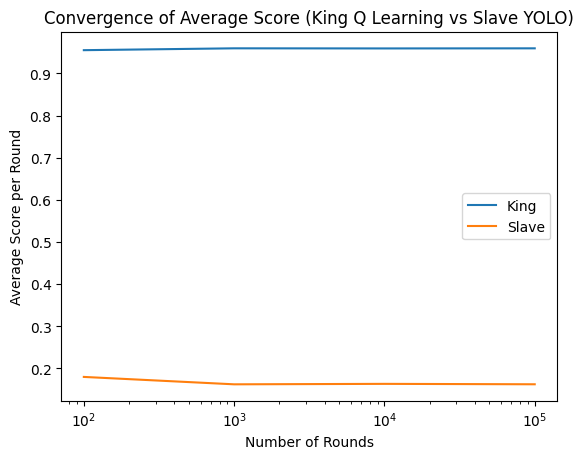

In [31]:
#benchmark trained agents compared to random and yolo policies
comparison = PolicyComparison(
    king_policy=king_vs_yolo.policy,
    slave_policy=yolo_policy,
    king_name="Q Learning",
    slave_name="YOLO"
)
# Run simulation
comparison.run_simulation()


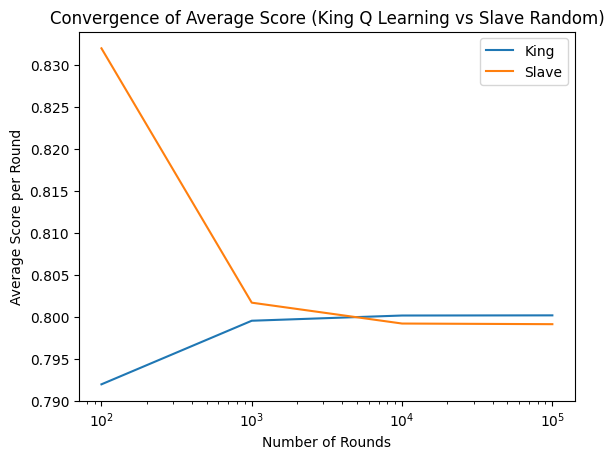

In [32]:
comparison = PolicyComparison(
    king_policy=king_vs_yolo.policy,
    slave_policy=random_policy,
    king_name="Q Learning",
    slave_name="Random"
)
# Run simulation
comparison.run_simulation()

In [33]:
king_self.q_table

{((1, 0, 4, 0, 1, 4), 0): -0.6724754731446366,
 ((1, 0, 3, 0, 1, 3), 0): -0.7752181076230925,
 ((1, 0, 2, 0, 1, 2), 1): -0.9942286547909319,
 ((1, 0, 3, 0, 1, 3), 1): -0.9741451430245219,
 ((1, 0, 2, 0, 1, 2), 0): -0.8553189075553598,
 ((1, 0, 1, 0, 1, 1), 0): -0.9440096478165112,
 ((1, 0, 0, 0, 1, 0), 1): -0.9999999999999996,
 ((1, 0, 1, 0, 1, 1), 1): -0.9893192963340132,
 ((1, 0, 4, 0, 1, 4), 1): -0.9997619985210068}

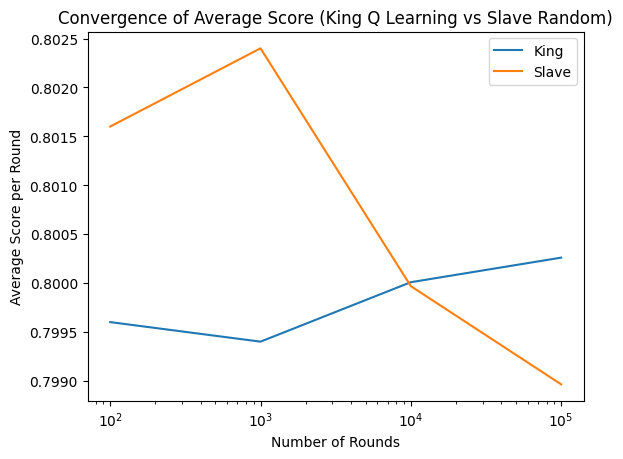

In [34]:
comparison = PolicyComparison(
    king_policy=king_self.policy,
    slave_policy=random_policy,
    king_name="Q Learning",
    slave_name="Random"
)
# Run simulation
comparison.run_simulation()

Deep Q Network. 

Given a state, the Q learning method picks the best action available by looking what which action has th e highest Q value. Instead of constructing a table and adjusting the values, we use a neural network to aprroximate the Q values

In [35]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)


In [36]:
class DeepQAgent(Player):
    def __init__(self, role, learning_rate=1e-3, gamma=0.99, buffer_size=10000, epsilon=0.1):
        # Initialize DQN components first
        self.role = role
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_net = DQN(4, 2)
        self.target_net = DQN(4, 2)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = 64
        self.last_state = None
        self.last_action = None
        
        # Initialize Player components
        if role == "King":
            hand = ["C","C","C","C","K"]
        else:
            hand = ["C","C","C","C","S"]
            
        # Pass self.policy_adapter as the policy function to the parent Player class
        super().__init__(role, hand, self.policy_adapter)
        
    def get_valid_actions(self, hand):
        actions = []
        if "C" in hand:
            actions.append(0)
        if "K" in hand or "S" in hand:
            actions.append(1)
        return actions

    def get_state(self, hand, opponent_hand):
        # Construct state vector [My Special, My C, Opp Special, Opp C]
        my_special = hand.count("K") + hand.count("S")
        my_c = hand.count("C")
        opp_special = opponent_hand.count("K") + opponent_hand.count("S")
        opp_c = opponent_hand.count("C")
        return np.array([my_special, my_c, opp_special, opp_c], dtype=np.float32)

    def choose_action(self, hand, opponent_hand, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
            
        state = self.get_state(hand, opponent_hand)
        valid_actions = self.get_valid_actions(hand)
        
        if not valid_actions:
            return None, state

        if random.random() < epsilon:
            action = random.choice(valid_actions)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_net(state_tensor)
            
            # Mask invalid actions
            mask = torch.full(q_values.shape, float('-inf'))
            for a in valid_actions:
                mask[0, a] = 0
            
            masked_q_values = q_values + mask
            action = masked_q_values.argmax().item()
            
        return action, state

    def policy_adapter(self, hand, opponent_hand):
        # Adapter for ECardEnv / Player.play_card
        # We assume epsilon=0 (Greedy) when used as a fixed policy/opponent
        action, state = self.choose_action(hand, opponent_hand, epsilon=0)
        
        # Store for potential learning (if self-play)
        self.last_state = state
        self.last_action = action
        
        # Execute action
        card = None
        if action == 0: # Play C
            if "C" in hand:
                card = "C"
                hand.remove("C")
            else:
                card = hand.pop(0)
        elif action == 1: # Play Special
            if "K" in hand:
                card = "K"
                hand.remove("K")
            elif "S" in hand:
                card = "S"
                hand.remove("S")
            else:
                card = hand.pop(0)
        return card

    def learn(self, reward, next_hand, next_opponent_hand, done):
        if self.last_state is None or self.last_action is None:
            return
            
        next_state = self.get_state(next_hand, next_opponent_hand)
        
        # Push to buffer
        self.buffer.push(self.last_state, self.last_action, reward, next_state, done)
        
        # Update network
        self.update_network()

    def update_network(self):
        if len(self.buffer) < self.batch_size:
            return
        
        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)
        
        state = torch.FloatTensor(np.array(state))
        action = torch.LongTensor(action).unsqueeze(1)
        reward = torch.FloatTensor(reward).unsqueeze(1)
        next_state = torch.FloatTensor(np.array(next_state))
        done = torch.FloatTensor(done).unsqueeze(1)
        
        q_values = self.q_net(state).gather(1, action)
        
        with torch.no_grad():
            next_q_values = self.target_net(next_state).max(1)[0].unsqueeze(1)
            target_q_values = reward + (1 - done) * self.gamma * next_q_values
            
        loss = nn.MSELoss()(q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [45]:
# train DQN agent against YOLO opponent
def train_dqn_agent(episodes, opponent_policy, train_role="King"):
    # 1. Setup Agents
    king_agent = None
    slave_agent = None
    
    if train_role == "King":
        king_agent = DeepQAgent("King")
        if opponent_policy == "self_play":
            slave_agent = DeepQAgent("Slave")
    elif train_role == "Slave":
        slave_agent = DeepQAgent("Slave")
        if opponent_policy == "self_play":
            king_agent = DeepQAgent("King")
            
    # 2. Setup Environment
    # ECardEnv constructor takes 'opponent_policy' which is the SLAVE's policy.
    env_slave_policy = None
    
    if slave_agent:
        env_slave_policy = slave_agent.policy_adapter
    elif train_role == "King":
        # We are training King, so opponent (Slave) is the fixed policy passed in
        env_slave_policy = opponent_policy
    
    env = ECardEnv(opponent_policy=env_slave_policy)
    
    rewards_history = []
    
    policy_name = opponent_policy if isinstance(opponent_policy, str) else opponent_policy.__name__
    print(f"Starting DQN training: {train_role} vs {policy_name} for {episodes} episodes...")
    
    for ep in range(episodes):
        env.reset()
        done = False
        total_reward = 0
        
        while not done:
            # --- Determine King's Action ---
            king_action = 0
            
            if king_agent:
                # King is DQN
                current_king_hand = env.agent.hand.copy()
                current_slave_hand = env.opponent.hand.copy()
                king_action, state = king_agent.choose_action(current_king_hand, current_slave_hand)
                king_agent.last_state = state
                king_agent.last_action = king_action
            else:
                # King is Fixed Policy (Training Slave against Fixed King)
                # opponent_policy is the King's policy function here
                card = opponent_policy(env.agent.hand.copy(), env.opponent.hand.copy())
                if card == "C":
                    king_action = 0
                else:
                    king_action = 1
            
            # --- Environment Step ---
            # This executes King's move (king_action) AND Slave's move (via env_slave_policy)
            _, reward, done = env.step(king_action)
            
            # --- Learning ---
            next_king_hand = env.agent.hand
            next_slave_hand = env.opponent.hand
            
            if king_agent:
                king_agent.learn(reward, next_king_hand, next_slave_hand, done)
            
            if slave_agent:
                # Slave reward is opposite of King reward
                slave_agent.learn(-reward, next_slave_hand, next_king_hand, done)
                
            total_reward += reward
            
        rewards_history.append(total_reward)
        
        # Decay epsilon
        if (ep + 1) % 500 == 0:
            if king_agent:
                king_agent.epsilon = max(0.01, king_agent.epsilon * 0.95)
            if slave_agent:
                slave_agent.epsilon = max(0.01, slave_agent.epsilon * 0.95)

    return king_agent, slave_agent

In [47]:
deep_king, _ = train_dqn_agent(episodes=10000, opponent_policy=random_policy)

Starting DQN training: King vs random_policy for 10000 episodes...


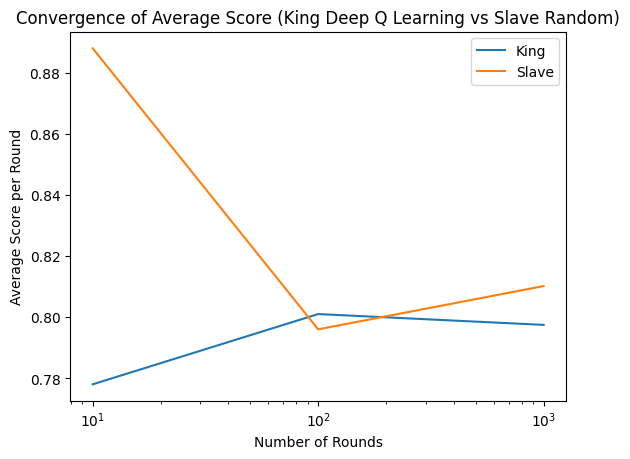

In [49]:
comparison = PolicyComparison(
    king_policy=deep_king.policy,
    slave_policy=random_policy,
    king_name="Deep Q Learning",
    slave_name="Random"
)
# Run simulation
comparison.run_simulation(n_rounds_list=[10, 100, 1000], replicates=50)

In [50]:
deep_king, _ = train_dqn_agent(episodes=10000, opponent_policy=yolo_policy)

Starting DQN training: King vs yolo_policy for 10000 episodes...


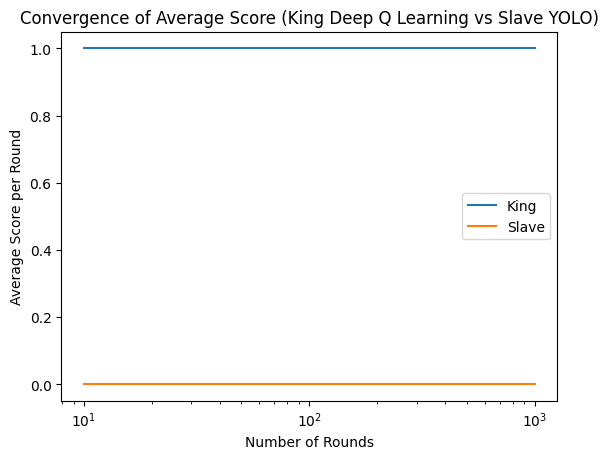

In [51]:
comparison = PolicyComparison(
    king_policy=deep_king.policy,
    slave_policy=yolo_policy,
    king_name="Deep Q Learning",
    slave_name="YOLO"
)
# Run simulation
comparison.run_simulation(n_rounds_list=[10, 100, 1000], replicates=50)